In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
import pystan
from viabel import all_bounds
from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_chivi,
                       make_stan_log_density,
                       adagrad_optimize)
from experiments import (get_samples_and_log_weights, 
                         improve_with_psis,
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         check_approx_accuracy,
                         print_bounds)

sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})

In [2]:
os.makedirs('../figures', exist_ok=True)
lims = dict(xlim=[-5,0], ylim=[-1,5])
mc_samples = 1000000  # number of Monte Carlo samples for estimating bounds and for PSIS

# Linear regression model example

We will approximate the posterior for the simple 2D robust linear regression model
$$\beta_i \sim \mathcal{N}(0, 10)$$
$$y_n | x_n, \beta, \sigma \sim \mathcal{T}_{10}(\beta^\top x_n, 1).$$

We will use Stan to compute (the gradient of) the model log density. 

In [3]:
regression_model_code = """data {
  int<lower=0> N;   // number of observations
  matrix[N, 2] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[2] beta;       // coefficients for predictors
}

model {
  beta ~ normal(0, 10);
  y ~ student_t(10, x * beta, 1);  // likelihood
}"""

In [4]:
regression_model = pystan.StanModel(model_code=regression_model_code, 
                                    model_name='regression_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL regression_model_e294fe8ce1a2cd2b3f225c66421026e6 NOW.


We generate 25 observations from the model with $\beta = (-2, 1)$.

In [5]:
np.random.seed(5039)
beta_gen = np.array([-2, 1])
N = 25
x = np.random.randn(N, 2).dot(np.array([[1,.75],[.75, 1]]))
y_raw = x.dot(beta_gen) + np.random.standard_t(10, N)
y = y_raw - np.mean(y_raw)

First, we generate ground truth samples using Stan's dynamic HMC implementation

In [6]:
data = dict(N=N, x=x, y=y)
fit = regression_model.sampling(data=data, iter=2000)

In [7]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)

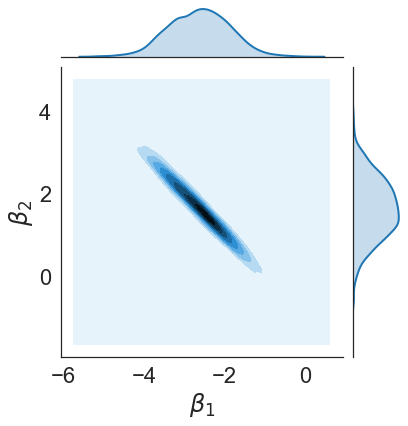

In [8]:
jp = sns.jointplot(x=fit['beta[1]'], y=fit['beta[2]'], kind='kde')
jp.set_axis_labels(r'$\beta_1$', r'$\beta_2$')
plt.show()

## Standard mean-field variational inference

Next, we compute a mean field variational approximation using standard variational inference (that is, minimizing the KL-divergence)

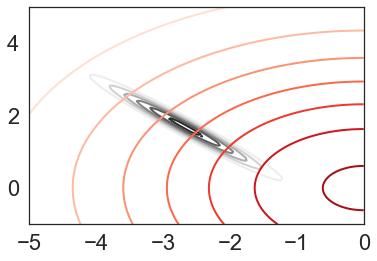

Average Loss = 23.28: 100%|██████████| 5000/5000 [00:17<00:00, 290.05it/s] 


In [9]:
mf_g_var_family = mean_field_gaussian_variational_family(2)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_g_var_family, stan_log_density, 100)

init_mean    = np.zeros(2)
init_log_std = np.ones(2)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 5000

plot_approx_and_exact_contours(stan_log_density, mf_g_var_family, init_var_param, **lims)
klvi_var_param, _, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

We can plot the negative ELBO to visually verify convergence

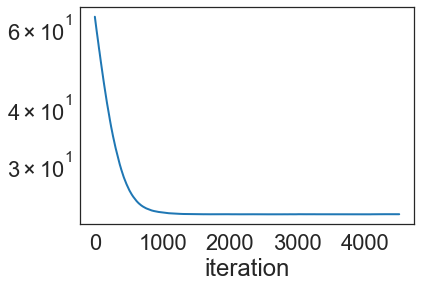

In [10]:
plot_history(klvi_history)

Due to the strong posterior correlation, the variational approximation dramatically underestimates uncertainty

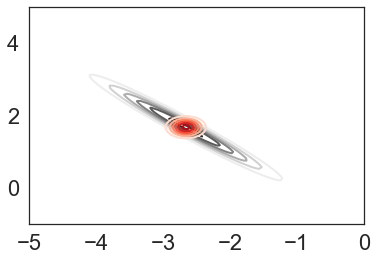

In [11]:
plot_approx_and_exact_contours(stan_log_density, mf_g_var_family, klvi_var_param, **lims,
                               savepath='../figures/robust-regression-mf-klvi.pdf')

In [12]:
check_approx_accuracy(mf_g_var_family, klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [-2.65745137  1.67896381]
stdevs = [0.15544228 0.1579547 ]

mean error             = 0.0438
stdev error            = 0.845
||cov error||_2^{1/2}  = 1.05
||true cov||_2^{1/2}   = 1.06


We can check approximation quality using `viabel`. All bounds suggest the approximation is not good. 

In [13]:
_, log_weights = get_samples_and_log_weights(stan_log_density, mf_g_var_family, klvi_var_param, mc_samples)
elbo = np.mean(log_weights)
var_dist_cov = mf_g_var_family.mean_and_cov(klvi_var_param)[1]
moment_bound_fn = lambda p: mf_g_var_family.pth_moment(p, klvi_var_param)

klvi_results = all_bounds(log_weights, q_var=var_dist_cov, moment_bound_fn=moment_bound_fn)

print_bounds(klvi_results)

Bounds on...
  2-Wasserstein   5.01
  2-divergence    9.01
  mean error      5.01
  stdev error     5.01
  sqrt cov error  7.2
  cov error       51.8


In [14]:
klvi_psis_results, _, _ = improve_with_psis(stan_log_density, mf_g_var_family, klvi_var_param,
                                            mc_samples, true_mean, true_cov, verbose=True)

khat = 0.929

mean   = [-2.67044815  1.70553397]
stdevs = [0.32165453 0.34026033]

mean error             = 0.0726
stdev error            = 0.599
||cov error||_2^{1/2}  = 0.958
||true cov||_2^{1/2}   = 1.06


/Users/jhuggins/Desktop/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


## Mean-field variational inference with CHIVI

We can repeat the same procedure, but this time using CHIVI and a Student t mean-field variational family. 

In [15]:
mf_t_var_family = mean_field_t_variational_family(2, 40)
chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 500)

init_var_param = klvi_var_param.copy()
init_var_param[2:] += 3

chivi_var_param, _, chivi_history, _ = \
    adagrad_optimize(n_iters, chivi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = -20.76: 100%|██████████| 5000/5000 [01:19<00:00, 62.90it/s] 


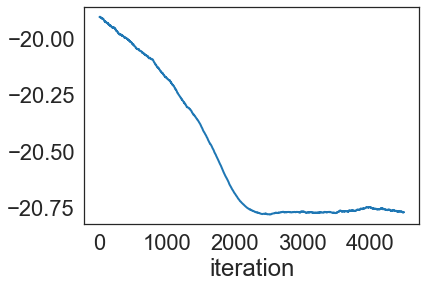

In [16]:
plot_history(chivi_history)

The variance is no longer so badly underestimated. But the variational approximation is still not very good, now greatly over-estimating the region with significant posterior mass. 

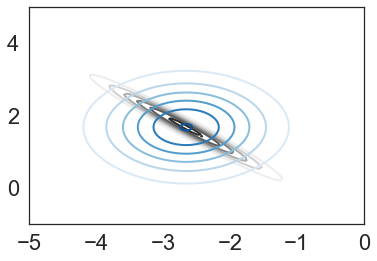

In [17]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, chivi_var_param, **lims,
                               cmap2='Blues', savepath='../figures/robust-regression-mf-chivi.pdf')

In [18]:
check_approx_accuracy(mf_t_var_family, chivi_var_param, true_mean, true_cov, verbose=True);

mean   = [-2.65238001  1.67981998]
stdevs = [0.8218465  0.83302913]

mean error             = 0.0412
stdev error            = 0.104
||cov error||_2^{1/2}  = 0.82
||true cov||_2^{1/2}   = 1.06


The fact that approximation is still not good is reflected is the large bounds:

In [19]:
_, log_weights = get_samples_and_log_weights(stan_log_density, mf_t_var_family, chivi_var_param, mc_samples)
var_dist_cov = mf_t_var_family.mean_and_cov(chivi_var_param)[1]
moment_bound_fn = lambda p: mf_t_var_family.pth_moment(p, chivi_var_param)

chivi_results = all_bounds(log_weights, q_var=var_dist_cov, log_norm_bound=elbo, moment_bound_fn=moment_bound_fn)

print_bounds(chivi_results)

Bounds on...
  2-Wasserstein   10.2
  2-divergence    5.15
  mean error      10.2
  stdev error     10.2
  sqrt cov error  14.9
  cov error       223


In [20]:
chivi_psis_results, _, _ = improve_with_psis(stan_log_density, mf_t_var_family, chivi_var_param,
                                             mc_samples, true_mean, true_cov, verbose=True)

khat = 0.352

mean   = [-2.65014734  1.67012292]
stdevs = [0.74965739 0.75974364]

mean error             = 0.0324
stdev error            = 0.000687
||cov error||_2^{1/2}  = 0.0375
||true cov||_2^{1/2}   = 1.06


/Users/jhuggins/Desktop/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


## A non-mean-field approximation

Finally, we obtain a very good approximation by using a Student t variational family with a full-rank scaling matrix. 

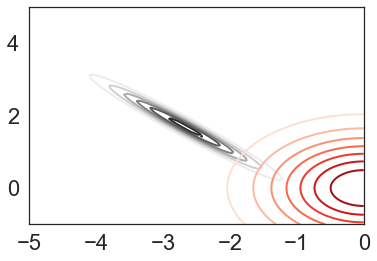

Average Loss = 24.587: 100%|██████████| 5000/5000 [00:25<00:00, 192.57it/s]


In [21]:
t_var_family = t_variational_family(2, 40)
full_klvi_objective_and_grad = black_box_klvi(t_var_family, stan_log_density, 100)

init_var_param = np.zeros(t_var_family.var_param_dim)
plot_approx_and_exact_contours(stan_log_density, t_var_family, init_var_param, **lims)
full_klvi_var_param, _, full_klvi_history, _ = \
    adagrad_optimize(n_iters, full_klvi_objective_and_grad, init_var_param, 
                     learning_rate=.1, learning_rate_end=.001)

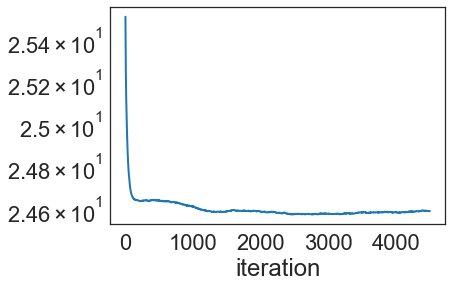

In [22]:
plot_history(full_klvi_history)

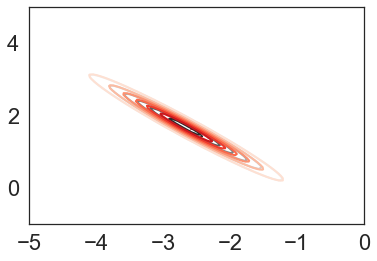

In [23]:
plot_approx_and_exact_contours(stan_log_density, t_var_family, full_klvi_var_param, **lims,
                               savepath='../figures/robust-regression-full-rank-klvi.pdf')

In [24]:
check_approx_accuracy(t_var_family, full_klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [-2.65193928  1.67255327]
stdevs = [0.75407997 0.76449699]

mean error             = 0.0354
stdev error            = 0.00715
||cov error||_2^{1/2}  = 0.124
||true cov||_2^{1/2}   = 1.06


Bounds computed using `viabel` -- and the 2-divergence bound in particular -- confirm that the approximation is accurate. 

In [25]:
_, log_weights = get_samples_and_log_weights(stan_log_density, t_var_family, full_klvi_var_param, mc_samples)
var_dist_cov = t_var_family.mean_and_cov(full_klvi_var_param)[1]
moment_bound_fn = lambda p: t_var_family.pth_moment(p, full_klvi_var_param)

full_klvi_results = all_bounds(log_weights, q_var=var_dist_cov, moment_bound_fn=moment_bound_fn)

print_bounds(full_klvi_results)

Bounds on...
  2-Wasserstein   0.702
  2-divergence    0.00366
  mean error      0.13
  stdev error     0.702
  sqrt cov error  1.58
  cov error       2.49


In [26]:
full_klvi_psis_results, _, _ = improve_with_psis(stan_log_density, t_var_family, full_klvi_var_param,
                                                 mc_samples, true_mean, true_cov, verbose=True)

khat = -0.85

mean   = [-2.65116961  1.67148771]
stdevs = [0.75326639 0.76397156]

mean error             = 0.0341
stdev error            = 0.00623
||cov error||_2^{1/2}  = 0.115
||true cov||_2^{1/2}   = 1.06


/Users/jhuggins/Desktop/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)
